In [153]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, ParameterGrid
import matplotlib.pyplot as plt
import seaborn as sns
!pip install emoji
import emoji
import re
import sklearn
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
import copy
from tqdm import tqdm
import nltk
from nltk.corpus import stopwords
from nltk import word_tokenize, pos_tag
from torch import nn
from torch.optim import Adam
import torch
from transformers import AutoConfig, AutoModel, AutoTokenizer, AdamW
from transformers import DebertaV2Tokenizer
from collections import Counter


#from google.colab import drive
#drive.mount('/content/drive')

nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [154]:
#Creazione dataset, la prima colonna è il testo intero del tweet

#datas = "/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_text.txt"
datas = '/kaggle/input/emotion-dataset/train_text.txt'
with open(datas, 'r', encoding='utf-8') as f:
    tweets = f.readlines()

# Rimuovi eventuali spazi vuoti o newline
tweets = [tweet.strip() for tweet in tweets]

# Crea un DataFrame
data = pd.DataFrame(tweets, columns=['text'])

#labels ="/content/drive/MyDrive/NLP/Challenge_2024/emotion/train_labels.txt"
labels = '/kaggle/input/emotion-dataset/train_labels.txt'
with open(labels, 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]

data.insert(1, "label", labels2)
texts = pd.DataFrame(data, columns=["text"])
data.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [155]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    3257 non-null   object
 1   label   3257 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 51.0+ KB


samples -> 3257
categories -> {0, 1, 2, 3}[4]
label
0    1400
3     855
1     708
2     294
Name: count, dtype: int64


<Axes: xlabel='label'>

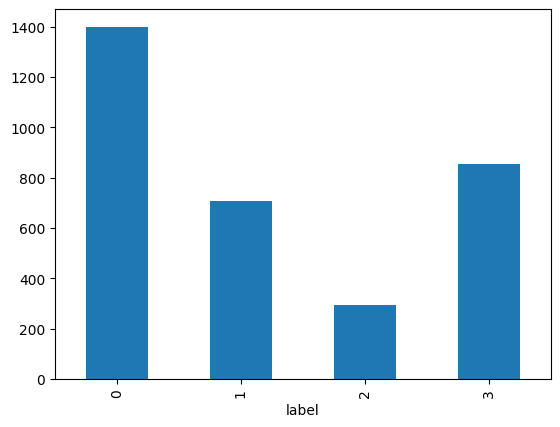

In [156]:
#Utilizzo il bert-model-cased per il task di classificazione
#0 = Rabbia
#1 = Gioia
#2 = Ottimismo
#3 = Tristezza
print('samples -> '+str(len(data)))
labels = set(data['label'])
numLabels = len(labels)
print('categories -> '+str(labels)+'['+str(len(labels))+']')
print(data['label'].value_counts())
data.groupby(['label']).size().plot.bar()

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


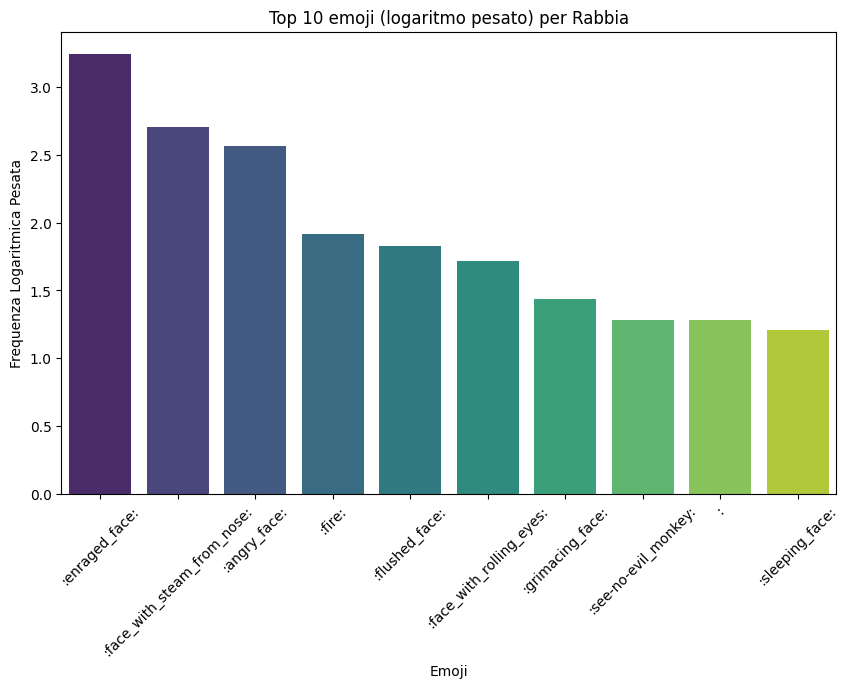

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


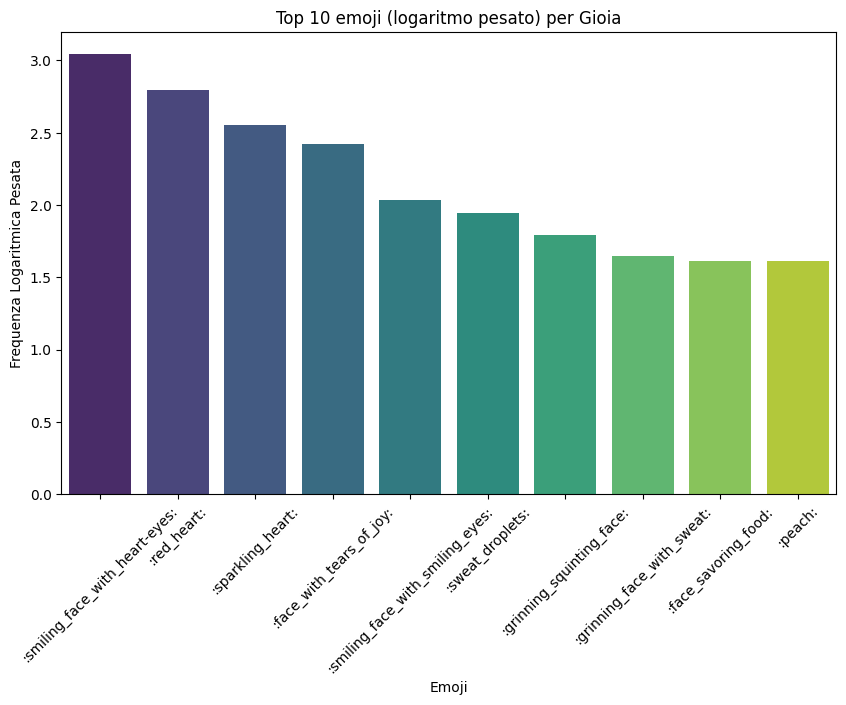

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


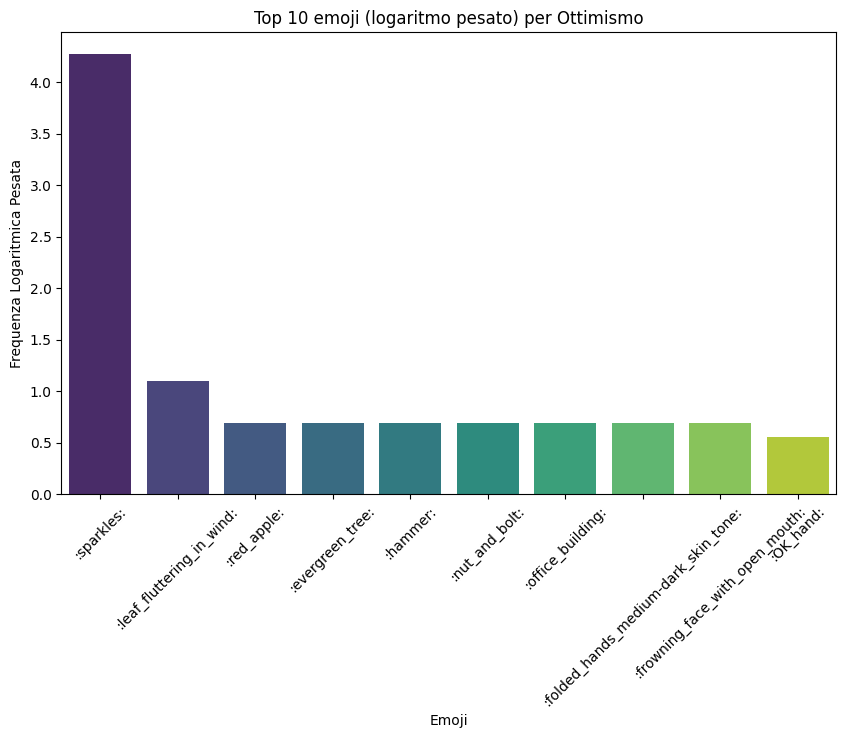

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


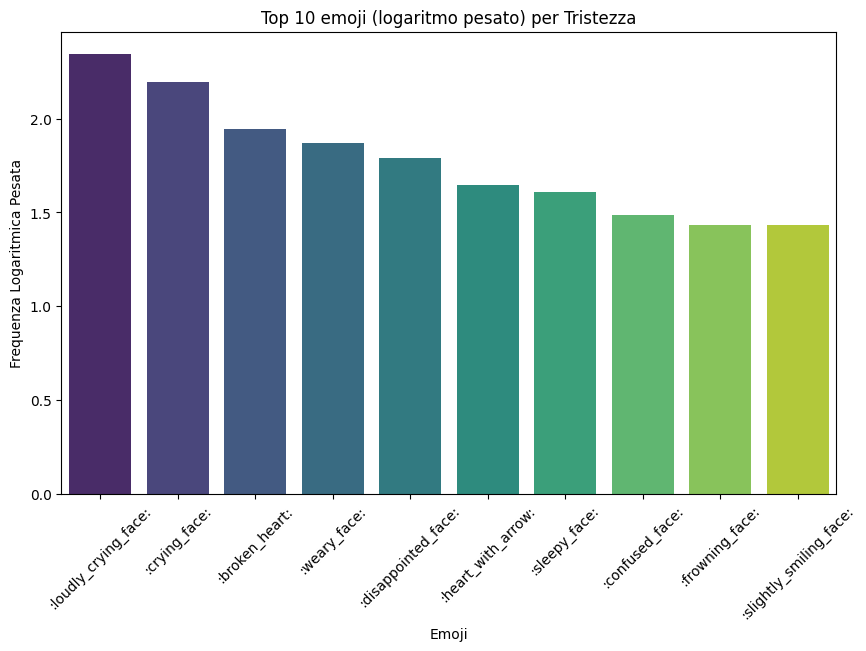

In [157]:
import pandas as pd
import numpy as np
from collections import Counter
import emoji
import matplotlib.pyplot as plt
import seaborn as sns

# Mappa delle etichette
label_map = {0: 'Rabbia', 1: 'Gioia', 2: 'Ottimismo', 3: 'Tristezza'}


emoji_freq = {emotion: Counter() for emotion in label_map.values()}
total_emoji_count = Counter()

# De-emojizzazione del testo
data['text'] = data['text'].apply(lambda text: emoji.demojize(text, delimiters=(" :", ": ")))

for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]

    emojis = [word for word in text.split() if word.startswith(":") and word.endswith(":")]

    for emj in emojis:
        emoji_freq[label][emj] += 1
        total_emoji_count[emj] += 1

normalized_emoji_freq = {emotion: Counter() for emotion in emoji_freq.keys()}

# Calcolo dello score logaritmico
for emotion, counter in emoji_freq.items():
    for emj, count in counter.items():
        term_freq = count / total_emoji_count[emj]
        log_weighted_freq = term_freq * np.log(total_emoji_count[emj] + 1)
        normalized_emoji_freq[emotion][emj] = log_weighted_freq

# Funzione per ottenere il vettore di punteggi per ogni tweet
def get_tweet_emoji_vector(text):
    emojis = [word for word in text.split() if word.startswith(":") and word.endswith(":")]

    emotion_scores = {emotion: 0 for emotion in label_map.values()}

    for emj in emojis:
        for emotion in normalized_emoji_freq:
            emotion_scores[emotion] += normalized_emoji_freq[emotion].get(emj, 0)

    num_emojis = len(emojis)
    if num_emojis > 0:
        for emotion in emotion_scores:
            emotion_scores[emotion] /= num_emojis

    return list(emotion_scores.values())

# Aggiungzione feature al dataset
data['emoji_emotion_scores'] = data['text'].apply(get_tweet_emoji_vector)

# Visualizzazione dei risultati
for emotion, counter in normalized_emoji_freq.items():
    top_emojis = counter.most_common(10)
    emojis, freqs = zip(*top_emojis) if top_emojis else ([], [])

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(emojis), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 emoji (logaritmo pesato) per {emotion}")
    plt.xlabel("Emoji")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()

In [158]:
data

,text,label,emoji_emotion_scores
0,“Worry is a down payment on a problem you may ...,2,"[0, 0, 0, 0]"
1,My roommate: it's okay that we can't spell bec...,0,"[0, 0, 0, 0]"
2,No but that's so cute. Atsu was probably shy a...,1,"[0, 0, 0, 0]"
3,Rooneys fucking untouchable isn't he? Been fuc...,0,"[0, 0, 0, 0]"
4,it's pretty depressing when u hit pan on ur fa...,3,"[0, 0, 0, 0]"
...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,"[0, 0, 0, 0]"
3253,The @user are in contention and hosting @user ...,3,"[0, 0, 0, 0]"
3254,@user @user @user @user @user as a fellow UP g...,0,"[0, 0, 0, 0]"
3255,You have a #problem? Yes! Can you do #somethin...,0,"[0, 0, 0, 0]"


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


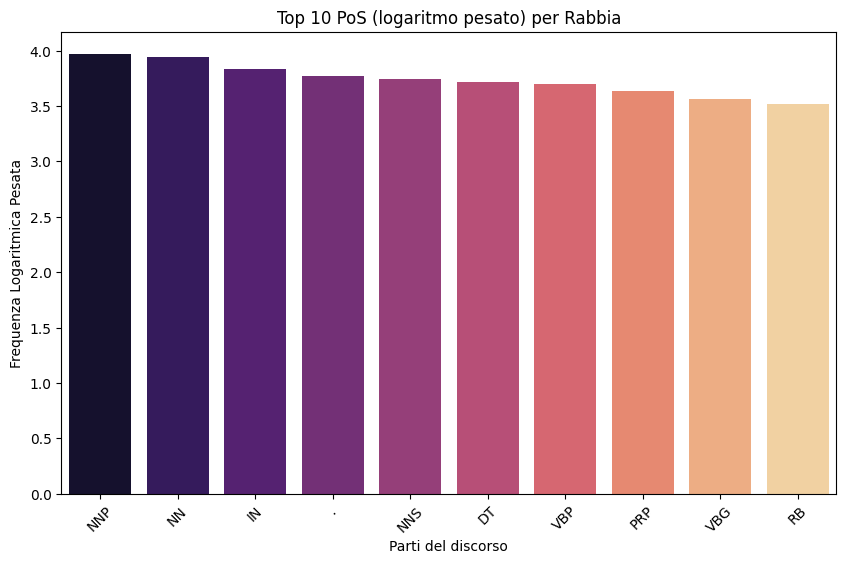

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


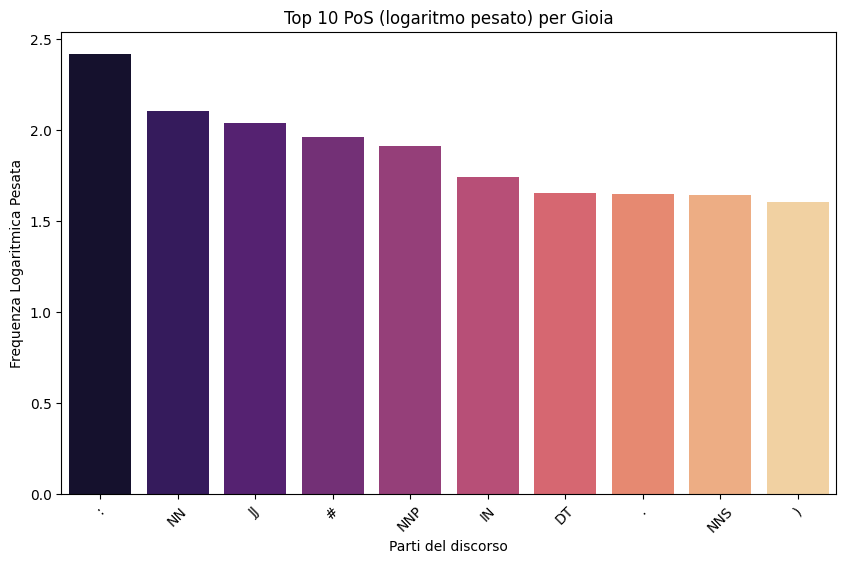

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


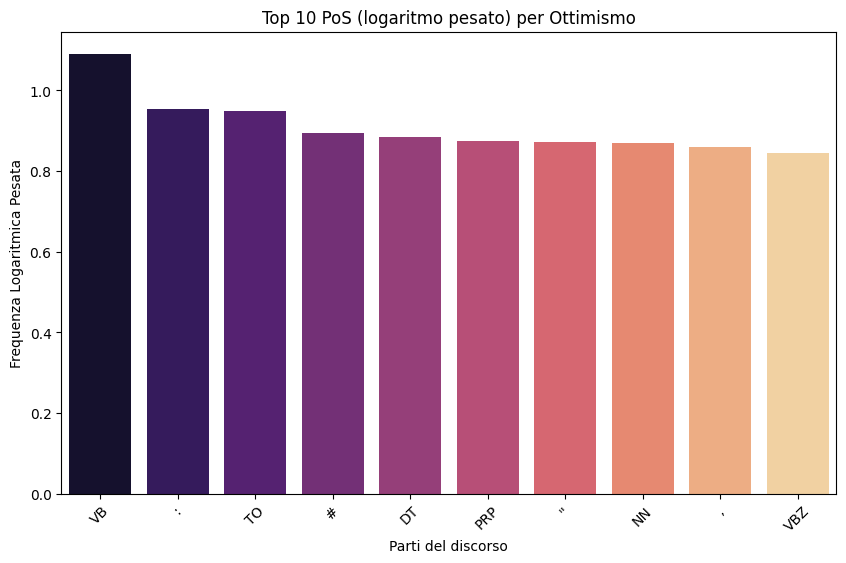

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


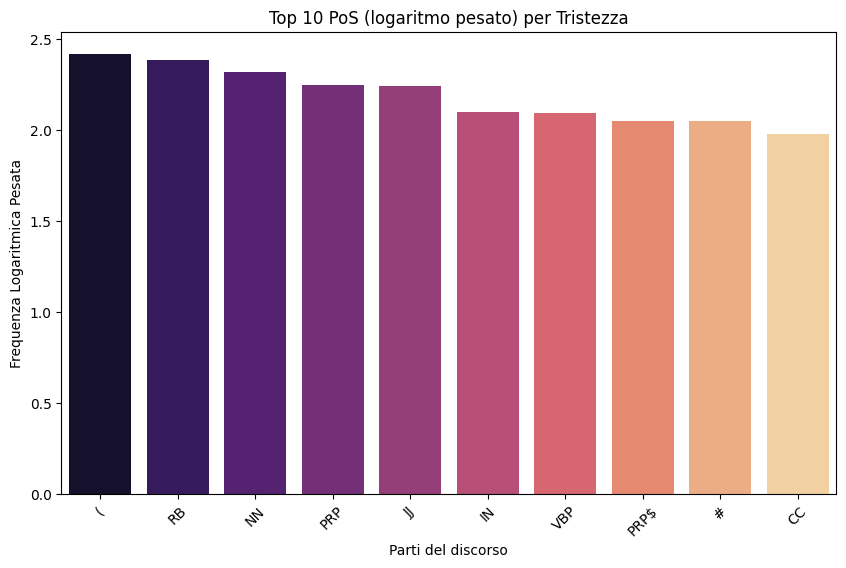

In [159]:
pos_freq = {emotion: Counter() for emotion in label_map.values()}
total_pos_count = Counter()

for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)

    for _, tag in tagged:
        pos_freq[label][tag] += 1
        total_pos_count[tag] += 1

# Normalizzazione PoS
normalized_pos_freq = {emotion: Counter() for emotion in pos_freq.keys()}
for emotion, counter in pos_freq.items():
    for tag, count in counter.items():
        term_freq = count / total_pos_count[tag]
        log_weighted_freq = term_freq * np.log(total_pos_count[tag] + 1)
        normalized_pos_freq[emotion][tag] = log_weighted_freq

# Funzione per ottenere il vettore di punteggi per ogni tweet basato su PoS
def get_tweet_pos_vector(text):
    tokens = word_tokenize(text)
    tagged = pos_tag(tokens)
    emotion_scores = {emotion: 0 for emotion in label_map.values()}
    for _, tag in tagged:
        for emotion in normalized_pos_freq:
            emotion_scores[emotion] += normalized_pos_freq[emotion].get(tag, 0)
    num_tags = len(tagged)
    if num_tags > 0:
        for emotion in emotion_scores:
            emotion_scores[emotion] /= num_tags
    return list(emotion_scores.values())

data['pos_emotion_scores'] = data['text'].apply(get_tweet_pos_vector)


for emotion, counter in normalized_pos_freq.items():
    top_pos = counter.most_common(10)
    pos_tags, freqs = zip(*top_pos) if top_pos else ([], [])
    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(pos_tags), y=list(freqs), palette="magma")
    plt.title(f"Top 10 PoS (logaritmo pesato) per {emotion}")
    plt.xlabel("Parti del discorso")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [160]:
data

,text,label,emoji_emotion_scores,pos_emotion_scores
0,“Worry is a down payment on a problem you may ...,2,"[0, 0, 0, 0]","[3.6267264787269027, 1.779068209636024, 0.8248..."
1,My roommate: it's okay that we can't spell bec...,0,"[0, 0, 0, 0]","[3.470041929536528, 1.7187670391211243, 0.8325..."
2,No but that's so cute. Atsu was probably shy a...,1,"[0, 0, 0, 0]","[3.5288137028970645, 1.6742311399743375, 0.740..."
3,Rooneys fucking untouchable isn't he? Been fuc...,0,"[0, 0, 0, 0]","[3.362575842078224, 1.661839975612509, 0.68048..."
4,it's pretty depressing when u hit pan on ur fa...,3,"[0, 0, 0, 0]","[3.590477888186092, 1.780412654080031, 0.75639..."
...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,"[0, 0, 0, 0]","[3.4500023697309046, 1.5589422475839745, 0.760..."
3253,The @user are in contention and hosting @user ...,3,"[0, 0, 0, 0]","[3.620645895633943, 1.8133916007935678, 0.7745..."
3254,@user @user @user @user @user as a fellow UP g...,0,"[0, 0, 0, 0]","[3.787815290962308, 1.8287279669309566, 0.7834..."
3255,You have a #problem? Yes! Can you do #somethin...,0,"[0, 0, 0, 0]","[3.421019132023666, 1.5353776707468128, 0.7696..."



Top 10 parole con logaritmo pesato per Rabbia:
angry: 4.0936
user: 3.7176
outrage: 3.6109
rage: 3.6082
anger: 3.5386
fuck: 3.5279
awful: 3.4358
bully: 3.4351
horrible: 3.2946
revenge: 3.1268

Top 10 parole con logaritmo pesato per Gioia:
hilarious: 3.4351
musically: 3.3322
broadcast: 3.2470
birthday: 2.9444
lively: 2.9017
happy: 2.7567
watch: 2.6348
cheer: 2.5146
hilarity: 2.4029
lol: 2.3070

Top 10 parole con logaritmo pesato per Ottimismo:
optimism: 2.9957
worry: 2.2834
faith: 2.1972
leadership: 1.9459
quote: 1.9343
fear: 1.9234
lord: 1.9226
success: 1.9226
optimist: 1.7824
difficulty: 1.6094

Top 10 parole con logaritmo pesato per Tristezza:
sad: 4.4376
depression: 4.0773
sadness: 3.8176
sadly: 3.1781
depressing: 2.5649
unhappy: 2.5483
depress: 2.4849
anxiety: 2.4710
lonely: 2.3979
mourn: 2.2590


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


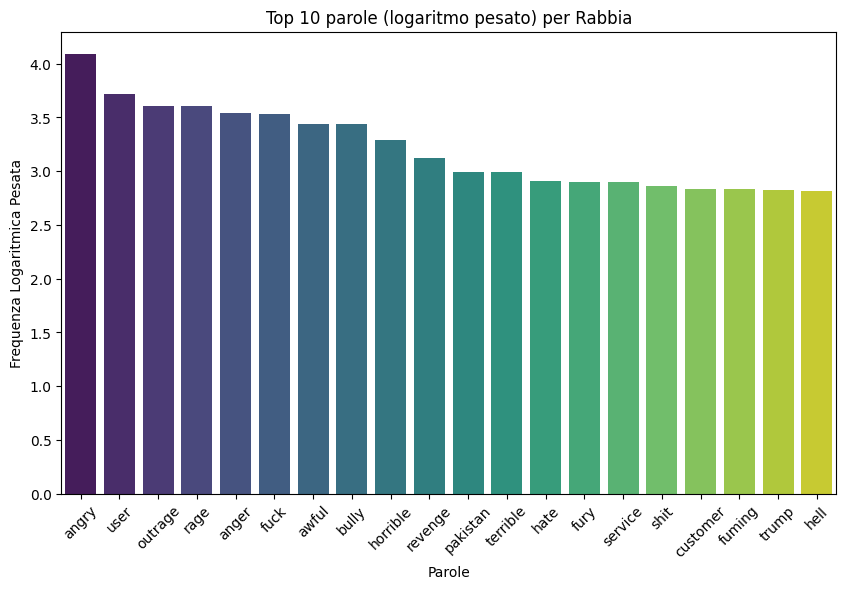

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


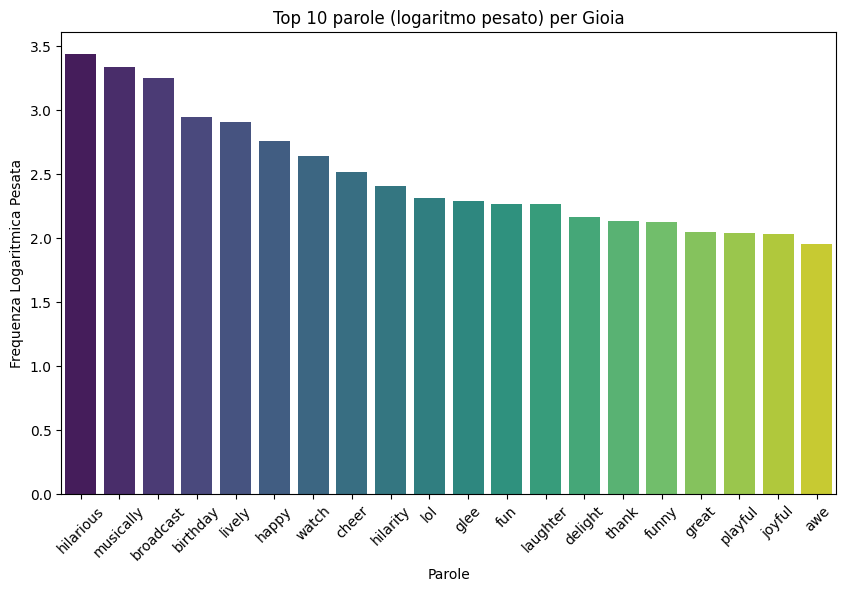

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


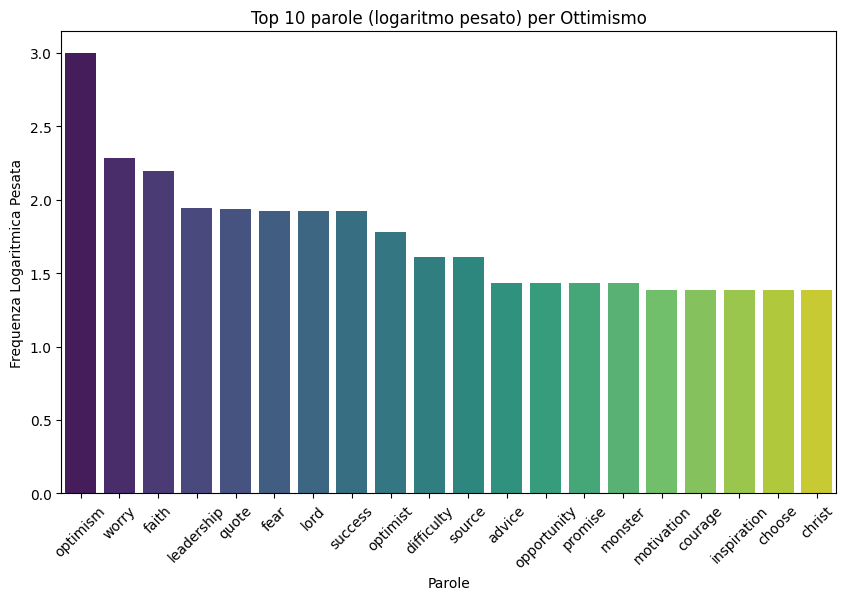

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


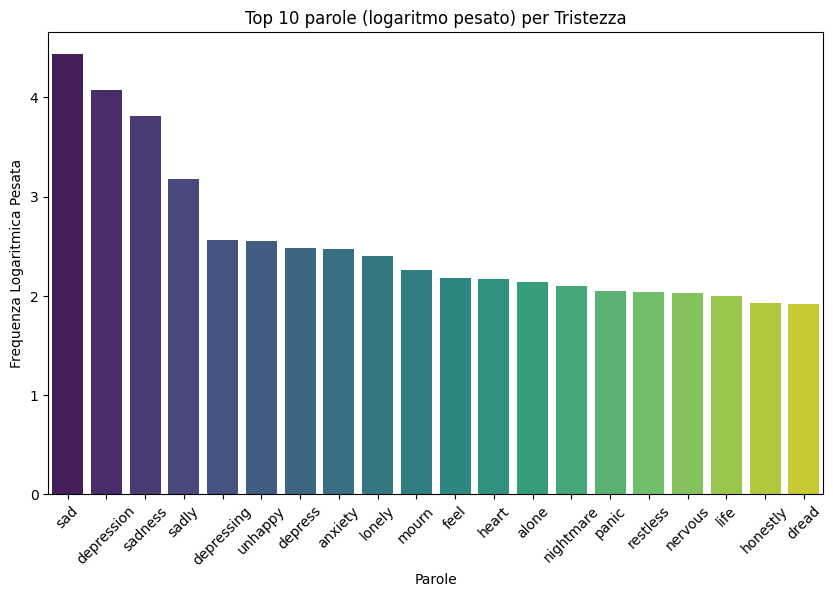

In [161]:
stop_words = set(stopwords.words('english'))
pos_map = {
    'JJ': 'Aggettivi',
    'NN': 'Sostantivi',
    'RB': 'Avverbi',
}

word_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_word_count = Counter()

label_map = {0: 'Rabbia', 1: 'Gioia', 2: 'Ottimismo', 3: 'Tristezza'}


for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]

    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words and not word.startswith('#')]

    tagged_words = pos_tag(tokens)

    for word, pos in tagged_words:
        if pos in pos_map:
            word_freq[label][word] += 1
            total_word_count[word] += 1

normalized_word_freq = {emotion: Counter() for emotion in word_freq.keys()}

for emotion, counter in word_freq.items():
    for word, count in counter.items():
        term_freq = count / total_word_count[word]
        log_weighted_freq = term_freq * np.log(total_word_count[word] + 1)
        normalized_word_freq[emotion][word] = log_weighted_freq

for emotion, counter in normalized_word_freq.items():
    print(f"\nTop 10 parole con logaritmo pesato per {emotion}:")
    for word, freq in counter.most_common(10):
        print(f"{word}: {freq:.4f}")

for emotion, counter in normalized_word_freq.items():
    top_words = counter.most_common(20)
    words, freqs = zip(*top_words)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(words), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 parole (logaritmo pesato) per {emotion}")
    plt.xlabel("Parole")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [162]:
word_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_word_count = Counter()

for _, row in data.iterrows():
    text = row['text']
    label = label_map[row['label']]

    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    tagged_words = pos_tag(tokens)
    for word, pos in tagged_words:
        if pos in pos_map:
            word_freq[label][word] += 1
            total_word_count[word] += 1


normalized_word_freq = {emotion: Counter() for emotion in word_freq.keys()}

for emotion, counter in word_freq.items():
    for word, count in counter.items():
        term_freq = count / total_word_count[word]
        log_weighted_freq = term_freq * np.log(total_word_count[word] + 1)
        normalized_word_freq[emotion][word] = log_weighted_freq


def get_tweet_vector(text):
    tokens = word_tokenize(text.lower())
    tokens = [word for word in tokens if word.isalnum() and word not in stop_words]
    emotion_scores = {'Rabbia': 0, 'Gioia': 0, 'Ottimismo': 0, 'Tristezza': 0}

    for word in tokens:
        for emotion in normalized_word_freq:
            emotion_scores[emotion] += normalized_word_freq[emotion].get(word, 0)

    num_words = len(tokens)
    if num_words > 0:
        for emotion in emotion_scores:
            emotion_scores[emotion] /= num_words
    return list(emotion_scores.values())

tweet_vectors = []
for _, row in data.iterrows():
    tweet_vector = get_tweet_vector(row['text'])
    tweet_vectors.append(tweet_vector)

tweet_feature_data = pd.DataFrame(tweet_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])

data['words_emotion_scores'] = tweet_feature_data.values.tolist()
data

,text,label,emoji_emotion_scores,pos_emotion_scores,words_emotion_scores
0,“Worry is a down payment on a problem you may ...,2,"[0, 0, 0, 0]","[3.6267264787269027, 1.779068209636024, 0.8248...","[0.3217492057353749, 0.044266415535094486, 1.0..."
1,My roommate: it's okay that we can't spell bec...,0,"[0, 0, 0, 0]","[3.470041929536528, 1.7187670391211243, 0.8325...","[0.7785015004839922, 0.4193027957645163, 0.030..."
2,No but that's so cute. Atsu was probably shy a...,1,"[0, 0, 0, 0]","[3.5288137028970645, 1.6742311399743375, 0.740...","[0.2157629154990156, 0.339539197741863, 0.0738..."
3,Rooneys fucking untouchable isn't he? Been fuc...,0,"[0, 0, 0, 0]","[3.362575842078224, 1.661839975612509, 0.68048...","[1.0159355358413762, 0.2277979439537182, 0.013..."
4,it's pretty depressing when u hit pan on ur fa...,3,"[0, 0, 0, 0]","[3.590477888186092, 1.780412654080031, 0.75639...","[0.9090620730361341, 0.28773433114489644, 0.09..."
...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,"[0, 0, 0, 0]","[3.4500023697309046, 1.5589422475839745, 0.760...","[0.6567781471798204, 0.3118917729587099, 0.062..."
3253,The @user are in contention and hosting @user ...,3,"[0, 0, 0, 0]","[3.620645895633943, 1.8133916007935678, 0.7745...","[1.1049345783266695, 0.4737146685284098, 0.158..."
3254,@user @user @user @user @user as a fellow UP g...,0,"[0, 0, 0, 0]","[3.787815290962308, 1.8287279669309566, 0.7834...","[2.144775185274386, 0.8731635677111113, 0.3281..."
3255,You have a #problem? Yes! Can you do #somethin...,0,"[0, 0, 0, 0]","[3.421019132023666, 1.5353776707468128, 0.7696...","[1.1014937861479612, 0.3351011035664421, 0.337..."


In [163]:
data['word_count'] = data['text'].apply(lambda x: len(x.split())) # quantità di parole
data['text_length'] = data['text'].apply(len)                     # lunghezza del testo
data

,text,label,emoji_emotion_scores,pos_emotion_scores,words_emotion_scores,word_count,text_length
0,“Worry is a down payment on a problem you may ...,2,"[0, 0, 0, 0]","[3.6267264787269027, 1.779068209636024, 0.8248...","[0.3217492057353749, 0.044266415535094486, 1.0...",17,104
1,My roommate: it's okay that we can't spell bec...,0,"[0, 0, 0, 0]","[3.470041929536528, 1.7187670391211243, 0.8325...","[0.7785015004839922, 0.4193027957645163, 0.030...",14,98
2,No but that's so cute. Atsu was probably shy a...,1,"[0, 0, 0, 0]","[3.5288137028970645, 1.6742311399743375, 0.740...","[0.2157629154990156, 0.339539197741863, 0.0738...",18,94
3,Rooneys fucking untouchable isn't he? Been fuc...,0,"[0, 0, 0, 0]","[3.362575842078224, 1.661839975612509, 0.68048...","[1.0159355358413762, 0.2277979439537182, 0.013...",13,102
4,it's pretty depressing when u hit pan on ur fa...,3,"[0, 0, 0, 0]","[3.590477888186092, 1.780412654080031, 0.75639...","[0.9090620730361341, 0.28773433114489644, 0.09...",11,65
...,...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,"[0, 0, 0, 0]","[3.4500023697309046, 1.5589422475839745, 0.760...","[0.6567781471798204, 0.3118917729587099, 0.062...",27,136
3253,The @user are in contention and hosting @user ...,3,"[0, 0, 0, 0]","[3.620645895633943, 1.8133916007935678, 0.7745...","[1.1049345783266695, 0.4737146685284098, 0.158...",14,77
3254,@user @user @user @user @user as a fellow UP g...,0,"[0, 0, 0, 0]","[3.787815290962308, 1.8287279669309566, 0.7834...","[2.144775185274386, 0.8731635677111113, 0.3281...",18,95
3255,You have a #problem? Yes! Can you do #somethin...,0,"[0, 0, 0, 0]","[3.421019132023666, 1.5353776707468128, 0.7696...","[1.1014937861479612, 0.3351011035664421, 0.337...",14,70



Top 10 hashtag con logaritmo pesato per Rabbia:
#fuming: 3.4340
#rage: 3.2958
#angry: 3.2780
#awful: 3.2421
#anger: 3.1278
#horrible: 2.9974
#terrible: 2.9155
#shocking: 2.8863
#bully: 2.6495
#outrage: 2.6391

Top 10 hashtag con logaritmo pesato per Gioia:
#musically: 3.3322
#hilarious: 3.2189
#lively: 2.7081
#blues: 2.4629
#happy: 2.2590
#funny: 2.1972
#smile: 2.1375
#cheer: 1.9459
#lol: 1.8270
#rock: 1.7918

Top 10 hashtag con logaritmo pesato per Ottimismo:
#optimism: 2.3979
#quote: 2.3512
#faith: 2.0794
#leadership: 1.7918
#monster: 1.6094
#fear: 1.4960
#life: 1.4387
#relentless: 1.4334
#motivation: 1.3863
#promise: 1.3863

Top 10 hashtag con logaritmo pesato per Tristezza:
#sad: 3.8532
#depression: 3.6716
#sadness: 3.6636
#lost: 2.8165
#depressing: 2.7726
#anxiety: 2.7151
#mhchat: 2.4849
#nightmare: 2.4683
#unhappy: 1.9459
#restless: 1.9226


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


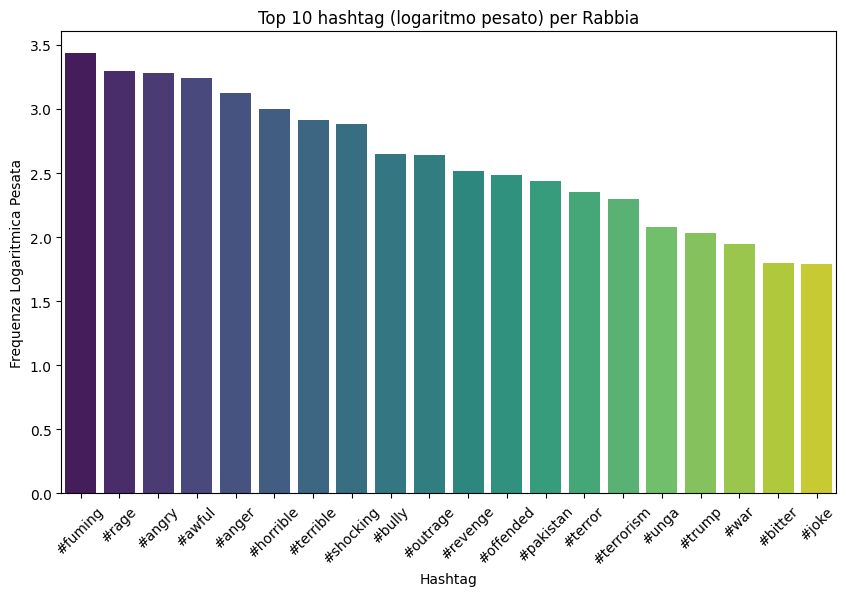

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


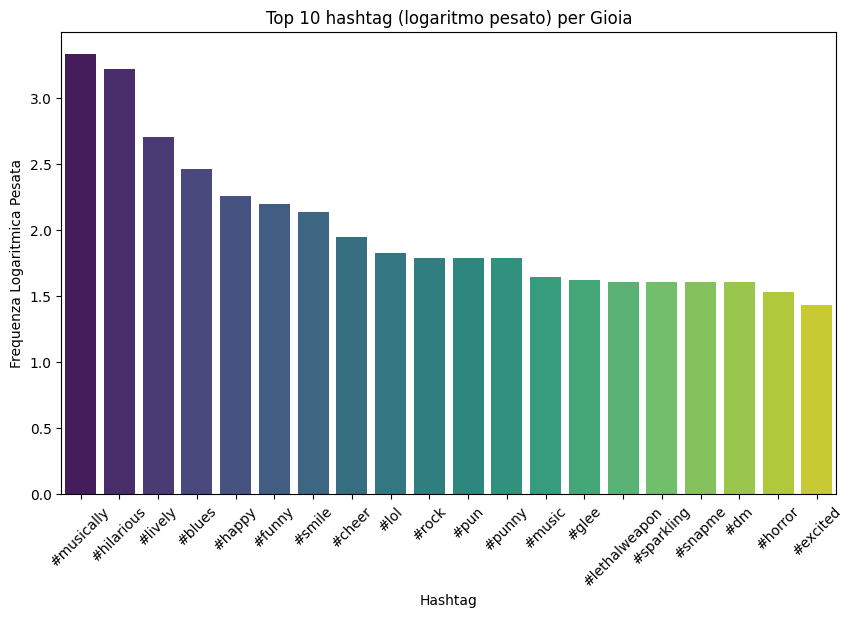

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


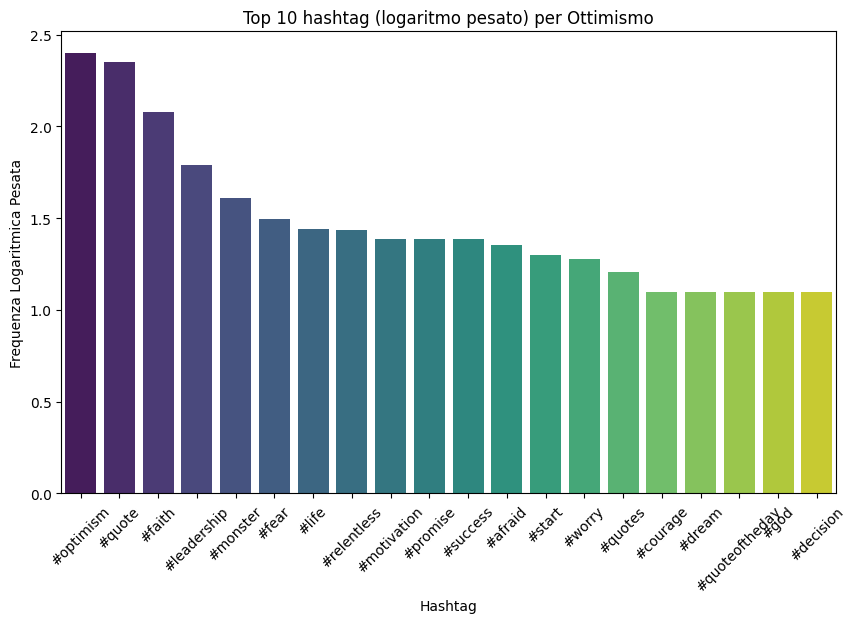

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


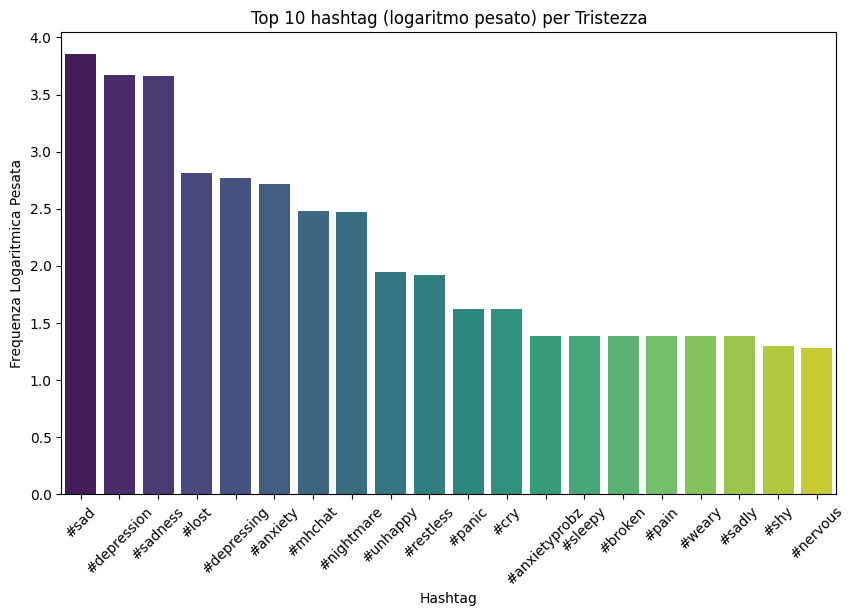

In [164]:
from collections import Counter

data['hashtags'] = data['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))

hashtag_freq = {emotion: Counter() for emotion in ['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza']}
total_hashtag_count = Counter()


for _, row in data.iterrows():
    hashtags = row['hashtags']
    label = label_map[row['label']]

    for hashtag in hashtags:
        hashtag_freq[label][hashtag] += 1
        total_hashtag_count[hashtag] += 1
normalized_hashtag_freq = {emotion: Counter() for emotion in hashtag_freq.keys()}

for emotion, counter in hashtag_freq.items():
    for hashtag, count in counter.items():
        term_freq = count / total_hashtag_count[hashtag]
        log_weighted_freq = term_freq * np.log(total_hashtag_count[hashtag] + 1)
        normalized_hashtag_freq[emotion][hashtag] = log_weighted_freq

for emotion, counter in normalized_hashtag_freq.items():
    print(f"\nTop 10 hashtag con logaritmo pesato per {emotion}:")
    for hashtag, freq in counter.most_common(10):
        print(f"{hashtag}: {freq:.4f}")

for emotion, counter in normalized_hashtag_freq.items():
    top_hashtags = counter.most_common(20)
    hashtags, freqs = zip(*top_hashtags)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=list(hashtags), y=list(freqs), palette="viridis")
    plt.title(f"Top 10 hashtag (logaritmo pesato) per {emotion}")
    plt.xlabel("Hashtag")
    plt.ylabel("Frequenza Logaritmica Pesata")
    plt.xticks(rotation=45)
    plt.show()


In [165]:
def get_hashtag_vector(hashtags):
    emotion_scores = {'Rabbia': 0, 'Gioia': 0, 'Ottimismo': 0, 'Tristezza': 0}

    for hashtag in hashtags:
        for emotion in normalized_hashtag_freq:
            emotion_scores[emotion] += normalized_hashtag_freq[emotion].get(hashtag, 0)
    return list(emotion_scores.values())
data['hastag_emotion_scores'] = data['hashtags'].apply(get_hashtag_vector)
data = data.drop(columns=['hashtags'])



In [166]:
data

,text,label,emoji_emotion_scores,pos_emotion_scores,words_emotion_scores,word_count,text_length,hastag_emotion_scores
0,“Worry is a down payment on a problem you may ...,2,"[0, 0, 0, 0]","[3.6267264787269027, 1.779068209636024, 0.8248...","[0.3217492057353749, 0.044266415535094486, 1.0...",17,104,"[0.2558427881104495, 0, 4.457267770900193, 0.7..."
1,My roommate: it's okay that we can't spell bec...,0,"[0, 0, 0, 0]","[3.470041929536528, 1.7187670391211243, 0.8325...","[0.7785015004839922, 0.4193027957645163, 0.030...",14,98,"[3.4648541411840386, 0.8028320571036187, 0, 0...."
2,No but that's so cute. Atsu was probably shy a...,1,"[0, 0, 0, 0]","[3.5288137028970645, 1.6742311399743375, 0.740...","[0.2157629154990156, 0.339539197741863, 0.0738...",18,94,"[0, 0, 0, 0]"
3,Rooneys fucking untouchable isn't he? Been fuc...,0,"[0, 0, 0, 0]","[3.362575842078224, 1.661839975612509, 0.68048...","[1.0159355358413762, 0.2277979439537182, 0.013...",13,102,"[0, 0, 0, 0]"
4,it's pretty depressing when u hit pan on ur fa...,3,"[0, 0, 0, 0]","[3.590477888186092, 1.780412654080031, 0.75639...","[0.9090620730361341, 0.28773433114489644, 0.09...",11,65,"[0, 0, 0, 0]"
...,...,...,...,...,...,...,...,...
3252,I get discouraged because I try for 5 fucking ...,3,"[0, 0, 0, 0]","[3.4500023697309046, 1.5589422475839745, 0.760...","[0.6567781471798204, 0.3118917729587099, 0.062...",27,136,"[0, 0, 0, 0]"
3253,The @user are in contention and hosting @user ...,3,"[0, 0, 0, 0]","[3.620645895633943, 1.8133916007935678, 0.7745...","[1.1049345783266695, 0.4737146685284098, 0.158...",14,77,"[0.07863651265448651, 0, 0, 3.853189120069839]"
3254,@user @user @user @user @user as a fellow UP g...,0,"[0, 0, 0, 0]","[3.787815290962308, 1.8287279669309566, 0.7834...","[2.144775185274386, 0.8731635677111113, 0.3281...",18,95,"[0, 0, 0, 0]"
3255,You have a #problem? Yes! Can you do #somethin...,0,"[0, 0, 0, 0]","[3.421019132023666, 1.5353776707468128, 0.7696...","[1.1014937861479612, 0.3351011035664421, 0.337...",14,70,"[1.0114042647073518, 0, 1.4735023850806486, 0]"


In [167]:
enc = OrdinalEncoder()
labels = data["label"]
data2 = data.drop("text", axis=1)

In [168]:
data2['emoji_rabbia_scores'] = [x[0] for x in data['emoji_emotion_scores']]
data2['emoji_gioia_scores'] = [x[1] for x in data['emoji_emotion_scores']]
data2['emoji_optym_scores'] = [x[2] for x in data['emoji_emotion_scores']]
data2['emoji_tristezza_scores'] = [x[3] for x in data['emoji_emotion_scores']]
data2['word_rabbia_scores'] = [x[0] for x in data['words_emotion_scores']]
data2['word_gioia_scores'] = [x[1] for x in data['words_emotion_scores']]
data2['word_optym_scores'] = [x[2] for x in data['words_emotion_scores']]
data2['word_tristezza_scores'] = [x[3] for x in data['words_emotion_scores']]
data2['hastag_rabbia_scores'] = [x[0] for x in data['hastag_emotion_scores']]
data2['hastag_gioia_scores'] = [x[1] for x in data['hastag_emotion_scores']]
data2['hastag_optym_scores'] = [x[2] for x in data['hastag_emotion_scores']]
data2['hastag_tristezza_scores'] = [x[3] for x in data['hastag_emotion_scores']]

In [169]:
data2 = data2.drop(columns=['emoji_emotion_scores','words_emotion_scores','hastag_emotion_scores', 'pos_emotion_scores'])
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3257 entries, 0 to 3256
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   label                    3257 non-null   int64  
 1   word_count               3257 non-null   int64  
 2   text_length              3257 non-null   int64  
 3   emoji_rabbia_scores      3257 non-null   float64
 4   emoji_gioia_scores       3257 non-null   float64
 5   emoji_optym_scores       3257 non-null   float64
 6   emoji_tristezza_scores   3257 non-null   float64
 7   word_rabbia_scores       3257 non-null   float64
 8   word_gioia_scores        3257 non-null   float64
 9   word_optym_scores        3257 non-null   float64
 10  word_tristezza_scores    3257 non-null   float64
 11  hastag_rabbia_scores     3257 non-null   float64
 12  hastag_gioia_scores      3257 non-null   float64
 13  hastag_optym_scores      3257 non-null   float64
 14  hastag_tristezza_scores 

In [170]:
data2

,label,word_count,text_length,emoji_rabbia_scores,emoji_gioia_scores,emoji_optym_scores,emoji_tristezza_scores,word_rabbia_scores,word_gioia_scores,word_optym_scores,word_tristezza_scores,hastag_rabbia_scores,hastag_gioia_scores,hastag_optym_scores,hastag_tristezza_scores
0,2,17,104,0.0,0.0,0.0,0.0,0.321749,0.044266,1.099148,0.311815,0.255843,0.000000,4.457268,0.767528
1,0,14,98,0.0,0.0,0.0,0.0,0.778502,0.419303,0.030535,0.263587,3.464854,0.802832,0.000000,0.126763
2,1,18,94,0.0,0.0,0.0,0.0,0.215763,0.339539,0.073884,0.406061,0.000000,0.000000,0.000000,0.000000
3,0,13,102,0.0,0.0,0.0,0.0,1.015936,0.227798,0.013032,0.239959,0.000000,0.000000,0.000000,0.000000
4,3,11,65,0.0,0.0,0.0,0.0,0.909062,0.287734,0.099106,0.920618,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,3,27,136,0.0,0.0,0.0,0.0,0.656778,0.311892,0.062576,0.357996,0.000000,0.000000,0.000000,0.000000
3253,3,14,77,0.0,0.0,0.0,0.0,1.104935,0.473715,0.158285,1.497903,0.078637,0.000000,0.000000,3.853189
3254,0,18,95,0.0,0.0,0.0,0.0,2.144775,0.873164,0.328122,0.799548,0.000000,0.000000,0.000000,0.000000
3255,0,14,70,0.0,0.0,0.0,0.0,1.101494,0.335101,0.337615,0.857974,1.011404,0.000000,1.473502,0.000000


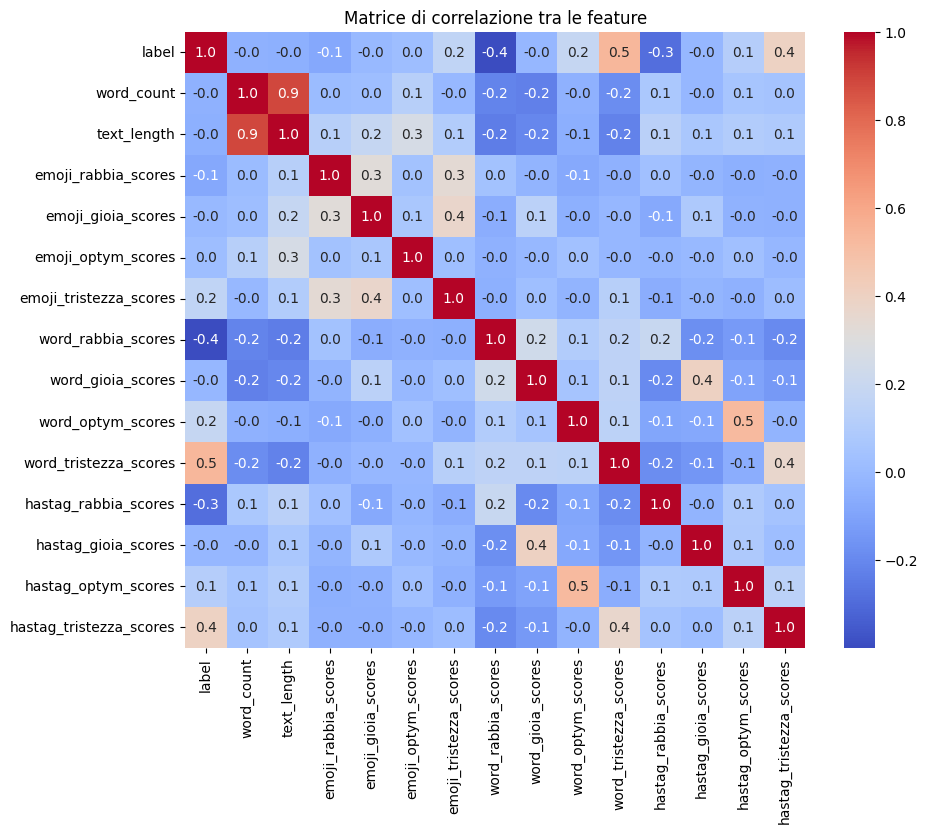

In [171]:
plt.figure(figsize=(10, 8))
sns.heatmap(data2.corr(), cmap="coolwarm", annot=True, fmt=".1f")
plt.title("Matrice di correlazione tra le feature")
plt.show()

In [172]:
data2 = data2.drop(columns=['word_count','text_length'])
data2

,label,emoji_rabbia_scores,emoji_gioia_scores,emoji_optym_scores,emoji_tristezza_scores,word_rabbia_scores,word_gioia_scores,word_optym_scores,word_tristezza_scores,hastag_rabbia_scores,hastag_gioia_scores,hastag_optym_scores,hastag_tristezza_scores
0,2,0.0,0.0,0.0,0.0,0.321749,0.044266,1.099148,0.311815,0.255843,0.000000,4.457268,0.767528
1,0,0.0,0.0,0.0,0.0,0.778502,0.419303,0.030535,0.263587,3.464854,0.802832,0.000000,0.126763
2,1,0.0,0.0,0.0,0.0,0.215763,0.339539,0.073884,0.406061,0.000000,0.000000,0.000000,0.000000
3,0,0.0,0.0,0.0,0.0,1.015936,0.227798,0.013032,0.239959,0.000000,0.000000,0.000000,0.000000
4,3,0.0,0.0,0.0,0.0,0.909062,0.287734,0.099106,0.920618,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,3,0.0,0.0,0.0,0.0,0.656778,0.311892,0.062576,0.357996,0.000000,0.000000,0.000000,0.000000
3253,3,0.0,0.0,0.0,0.0,1.104935,0.473715,0.158285,1.497903,0.078637,0.000000,0.000000,3.853189
3254,0,0.0,0.0,0.0,0.0,2.144775,0.873164,0.328122,0.799548,0.000000,0.000000,0.000000,0.000000
3255,0,0.0,0.0,0.0,0.0,1.101494,0.335101,0.337615,0.857974,1.011404,0.000000,1.473502,0.000000


In [173]:
x_train = data['text']
y_train = data2['label']
word_rabbia_scores = data2['word_rabbia_scores']
word_gioia_scores = data2['word_gioia_scores']
word_optym_scores = data2['word_optym_scores']
word_tristezza_scores = data2['word_tristezza_scores']
emoji_rabbia_scores = data2['emoji_rabbia_scores']
emoji_gioia_scores = data2['emoji_gioia_scores']
emoji_optym_scores = data2['emoji_optym_scores']
emoji_tristezza_scores = data2['emoji_tristezza_scores']
hastag_rabbia_scores = data2['hastag_rabbia_scores']
hastag_gioia_scores = data2['hastag_gioia_scores']
hastag_optym_scores = data2['hastag_optym_scores']
hastag_tristezza_scores = data2['hastag_tristezza_scores']

In [174]:
with open("/kaggle/input/emotion-dataset/val_text.txt", 'r', encoding='utf-8') as f:
    tweets = f.readlines()

# Rimuovi eventuali spazi vuoti o newline
tweets = [tweet.strip() for tweet in tweets]
val_data = pd.DataFrame(tweets, columns=['text'])

with open("/kaggle/input/emotion-dataset/val_labels.txt", 'r', encoding='utf-8') as f:
    labels = f.readlines()

labels2 = [int(label.strip()) for label in labels]
val_data = pd.DataFrame(tweets, columns=['text'])
val_data['label'] = labels2
val_data

,text,label
0,"@user @user Oh, hidden revenge and anger...I r...",0
1,if not then #teamchristine bc all tana has don...,0
2,Hey @user #Fields in #skibbereen give your onl...,0
3,Why have #Emmerdale had to rob #robron of havi...,0
4,@user I would like to hear a podcast of you go...,0
...,...,...
369,@user @user If #trump #whitehouse aren't held ...,0
370,@user Which #chutiya #producer #invested in #c...,0
371,Russia story will infuriate Trump today. Media...,0
372,Shit getting me irritated 😠,0


In [175]:
# Applicazione della funzione ai tweet e creazione delle feature
tweet_vectors = []
for _, row in val_data.iterrows():
    tweet_vector = get_tweet_vector(row['text'])
    tweet_vectors.append(tweet_vector)

# Convertilo in un DataFrame per visualizzare le feature
tweet_feature_data = pd.DataFrame(tweet_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])
val_data['words_emotion_scores'] = tweet_feature_data.values.tolist()

val_data['word_rabbia_scores'] = [x[0] for x in val_data['words_emotion_scores']]
val_data['word_gioia_scores'] = [x[1] for x in val_data['words_emotion_scores']]
val_data['word_optym_scores'] = [x[2] for x in val_data['words_emotion_scores']]
val_data['word_tristezza_scores'] = [x[3] for x in val_data['words_emotion_scores']]
val_data = val_data.drop(columns=['words_emotion_scores'])




emoji_vectors = []
for _, row in val_data.iterrows():
    emoji_vector = get_tweet_emoji_vector(row['text'])
    emoji_vectors.append(emoji_vector)

emoji_feature_data = pd.DataFrame(emoji_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])
val_data['emoji_emotion_scores'] = emoji_feature_data.values.tolist()

val_data['emoji_rabbia_scores'] = [x[0] for x in val_data['emoji_emotion_scores']]
val_data['emoji_gioia_scores'] = [x[1] for x in val_data['emoji_emotion_scores']]
val_data['emoji_optym_scores'] = [x[2] for x in val_data['emoji_emotion_scores']]
val_data['emoji_tristezza_scores'] = [x[3] for x in val_data['emoji_emotion_scores']]

val_data = val_data.drop(columns=['emoji_emotion_scores'])

import re
from collections import Counter

# Estrazione degli hashtag
val_data['hashtags'] = val_data['text'].apply(lambda x: re.findall(r"#\w+", x.lower()))

# Applicazione della funzione ai tweet e creazione delle feature
hashtag_vectors = []
for _, row in val_data.iterrows():
    hashtag_vector = get_hashtag_vector(row['hashtags'])
    hashtag_vectors.append(hashtag_vector)

# Convertilo in un DataFrame per visualizzare le feature
hashtag_feature_data = pd.DataFrame(hashtag_vectors, columns=['Rabbia', 'Gioia', 'Ottimismo', 'Tristezza'])
val_data['hashtag_emotion_scores'] = hashtag_feature_data.values.tolist()

# Creazione di colonne separate per ciascuna emozione
val_data['hashtag_rabbia_scores'] = [x[0] for x in val_data['hashtag_emotion_scores']]
val_data['hashtag_gioia_scores'] = [x[1] for x in val_data['hashtag_emotion_scores']]
val_data['hashtag_optym_scores'] = [x[2] for x in val_data['hashtag_emotion_scores']]
val_data['hashtag_tristezza_scores'] = [x[3] for x in val_data['hashtag_emotion_scores']]

# Rimozione della colonna aggregata
val_data = val_data.drop(columns=['hashtag_emotion_scores', 'hashtags'])



In [176]:
val_data

,text,label,word_rabbia_scores,word_gioia_scores,word_optym_scores,word_tristezza_scores,emoji_rabbia_scores,emoji_gioia_scores,emoji_optym_scores,emoji_tristezza_scores,hashtag_rabbia_scores,hashtag_gioia_scores,hashtag_optym_scores,hashtag_tristezza_scores
0,"@user @user Oh, hidden revenge and anger...I r...",0,1.903377,0.551221,0.174225,0.600786,0,0,0,0,0.000000,0.000000,0.00000,0.000000
1,if not then #teamchristine bc all tana has don...,0,0.770668,0.147148,0.038505,0.259726,0,0,0,0,0.000000,0.000000,0.00000,0.000000
2,Hey @user #Fields in #skibbereen give your onl...,0,1.177822,0.302957,0.068018,0.344308,0,0,0,0,0.000000,0.000000,0.00000,0.000000
3,Why have #Emmerdale had to rob #robron of havi...,0,0.670438,0.274011,0.168171,0.411174,0,0,0,0,1.799379,0.327160,0.32716,0.490740
4,@user I would like to hear a podcast of you go...,0,0.810423,0.308031,0.252947,0.410009,0,0,0,0,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369,@user @user If #trump #whitehouse aren't held ...,0,1.153567,0.355600,0.083257,0.614730,0,0,0,0,2.897137,0.369678,0.00000,2.837978
370,@user Which #chutiya #producer #invested in #c...,0,0.918225,0.291055,0.075661,0.266516,0,0,0,0,0.000000,0.000000,0.00000,0.000000
371,Russia story will infuriate Trump today. Media...,0,0.738689,0.274814,0.085073,0.357155,0,0,0,0,0.000000,0.000000,0.00000,0.000000
372,Shit getting me irritated 😠,0,1.186757,0.000000,0.043441,0.086883,0,0,0,0,0.000000,0.000000,0.00000,0.000000


In [177]:
x_val = val_data['text']
word_rabbia_scores_val = val_data['word_rabbia_scores']
word_gioia_scores_val = val_data['word_gioia_scores']
word_optym_scores_val = val_data['word_optym_scores']
word_tristezza_scores_val = val_data['word_tristezza_scores']

emoji_rabbia_scores_val = val_data['emoji_rabbia_scores']
emoji_gioia_scores_val = val_data['emoji_gioia_scores']
emoji_optym_scores_val = val_data['emoji_optym_scores']
emoji_tristezza_scores_val = val_data['emoji_tristezza_scores']

hastag_rabbia_scores_val = val_data['hashtag_rabbia_scores']
hastag_gioia_scores_val = val_data['hashtag_gioia_scores']
hastag_optym_scores_val = val_data['hashtag_optym_scores']
hastag_tristezza_scores_val = val_data['hashtag_tristezza_scores']
label_val = val_data['label']

In [178]:
x_train = x_train.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))
x_val = x_val.apply(lambda x: x.replace('\r', ' ').replace('\n', ' '))

In [179]:
class Dataset(torch.utils.data.Dataset):

    def __init__(self, x, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores, emoji_rabbia_scores, emoji_gioia_scores, emoji_optym_scores, emoji_tristezza_scores, hastag_rabbia_scores, hastag_gioia_scores, hastag_optym_scores, hastag_tristezza_scores,  y, stopwords):

        # x e y sono series di pandas
        tokens_litt = [nltk.word_tokenize(text, language='english')
         for text in list(x)]
        text_clean = []

        if stopwords:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence if
                    not w.lower() in nltk.corpus.stopwords.words("english")]))
        else:
            for sentence in tqdm(tokens_litt, desc='Tokenizing ... '):
                text_clean.append(' '.join([w.lower() for w in sentence]))
            # ogni token è separato dall'altro con uno spazio

        self.texts = text_clean
        self.labels = [torch.tensor(label) for label in y]
        self.word_rabbia_scores = [torch.tensor(score) for score in word_rabbia_scores]
        self.word_gioia_scores = [torch.tensor(score) for score in word_gioia_scores]
        self.word_optym_scores = [torch.tensor(score) for score in word_optym_scores]
        self.word_tristezza_scores = [torch.tensor(score) for score in word_tristezza_scores]
        self.emoji_rabbia_scores = [torch.tensor(score) for score in emoji_rabbia_scores]
        self.emoji_gioia_scores = [torch.tensor(score) for score in emoji_gioia_scores]
        self.emoji_optym_scores = [torch.tensor(score) for score in emoji_optym_scores]
        self.emoji_tristezza_scores = [torch.tensor(score) for score in emoji_tristezza_scores]
        self.hastag_rabbia_scores = [torch.tensor(score) for score in hastag_rabbia_scores]
        self.hastag_gioia_scores = [torch.tensor(score) for score in hastag_gioia_scores]
        self.hastag_optym_scores = [torch.tensor(score) for score in hastag_optym_scores]
        self.hastag_tristezza_scores = [torch.tensor(score) for score in hastag_tristezza_scores]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):

        batch_texts = self.texts[idx]
        batch_labels = np.array(self.labels[idx])
        batch_word_rabbia_scores = np.array(self.word_rabbia_scores[idx])
        batch_word_gioia_scores = np.array(self.word_gioia_scores[idx])
        batch_word_optym_scores = np.array(self.word_optym_scores[idx])
        batch_word_tristezza_scores = np.array(self.word_tristezza_scores[idx])
        
        batc_emoji_rabbia_scores = np.array(self.emoji_rabbia_scores[idx])
        batc_emoji_gioia_scores = np.array(self.emoji_gioia_scores[idx])
        batc_emoji_optym_scores = np.array(self.emoji_optym_scores[idx])
        batc_emoji_tristezza_scores = np.array(self.emoji_tristezza_scores[idx])
        
        batc_hastag_gioia_scores = np.array(self.hastag_rabbia_scores[idx])
        batc_hastag_rabbia_scores = np.array(self.hastag_gioia_scores[idx])
        batc_hastag_optym_scores = np.array(self.hastag_optym_scores[idx])
        batc_hastag_tristezza_scores = np.array(self.hastag_tristezza_scores[idx])

        return batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batc_emoji_rabbia_scores, batc_emoji_gioia_scores, batc_emoji_optym_scores, batc_emoji_tristezza_scores, batc_hastag_gioia_scores, batc_hastag_rabbia_scores, batc_hastag_optym_scores, batc_hastag_tristezza_scores, batch_labels

In [180]:
#Iperparametri della rete
#Uso il modello bertweet-base
hyperparameters = {
    "epochs": 5,
    "learning_rate": 1e-5,
    "batch_size": 16,
    "dropout": 0.1,
    "stopwords": False,
    "language_model": "vinai/bertweet-base",
    "layers": 1,
    "h_dim": 768,
    "bilstm": True,
    "patience": 5,
    "min_delta": 0.01,
}

In [181]:
#creo i dataset
train_dataset = Dataset(x_train, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores, emoji_rabbia_scores, emoji_gioia_scores, emoji_optym_scores, emoji_tristezza_scores, hastag_rabbia_scores, hastag_gioia_scores, hastag_optym_scores, hastag_tristezza_scores ,y_train, hyperparameters["stopwords"])

val_dataset = Dataset(x_val, word_rabbia_scores_val, word_gioia_scores_val, word_optym_scores_val, word_tristezza_scores_val, emoji_rabbia_scores_val, emoji_gioia_scores_val, emoji_optym_scores_val, emoji_tristezza_scores_val, hastag_rabbia_scores_val, hastag_gioia_scores_val, hastag_optym_scores_val, hastag_tristezza_scores_val ,label_val, hyperparameters["stopwords"])

Tokenizing ... : 100%|██████████| 374/374 [00:00<00:00, 283870.74it/s]


In [182]:
extra_features = 12

class ClassifierDeep(nn.Module):
    def __init__(self, labels, hdim, dropout, model_name):
        super(ClassifierDeep, self).__init__()
        config = AutoConfig.from_pretrained(model_name)
        self.lm_model = AutoModel.from_pretrained(model_name, config=config)

        # Proiezione dell'output di BERT
        self.bert_projection = nn.Sequential(
            nn.Linear(hdim, hdim),
            nn.BatchNorm1d(hdim),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Proiezione delle extra features
        self.extra_feature_projection = nn.Sequential(
            nn.Linear(extra_features, hdim // 2),
            nn.BatchNorm1d(hdim // 2),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

        # Classificatore finale
        self.classifier = nn.Sequential(
            nn.Linear(hdim + (hdim // 2), hdim),
            nn.BatchNorm1d(hdim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hdim, labels)
        )

    def forward(self, input_id_text, attention_mask, word_rabbia_scores, word_gioia_scores, word_optym_scores, word_tristezza_scores, emoji_rabbia_scores, emoji_gioia_scores, emoji_optym_scores, emoji_tristezza_scores, hastag_rabbia_scores, hastag_gioia_scores, hastag_optym_scores, hastag_tristezza_scores):

        # Output da BERT
        output = self.lm_model(input_id_text, attention_mask).last_hidden_state
        output = output[:, 0, :]  # CLS token
        output = self.bert_projection(output)

        # Extra features (PoS, emoji scores)
        extra_features = torch.cat((word_rabbia_scores.unsqueeze(1), word_gioia_scores.unsqueeze(1),
                                    word_optym_scores.unsqueeze(1), word_tristezza_scores.unsqueeze(1)),
                                   emoji_rabbia_scores.unsqueeze(1), emoji_gioia_scores.unsqueeze(1),
                                   emoji_optym_scores.unsqueeze(1), emoji_tristezza_scores.unsqueeze(1),
                                   hastag_rabbia_scores.unsqueeze(1), hastag_gioia_scores.unsqueeze(1),
                                   hastag_optym_scores.unsqueeze(1), hastag_tristezza_scores.unsqueeze(1),
                                   dim=1)
        extra_features = self.extra_feature_projection(extra_features)

        # Fusione delle rappresentazioni
        combined = torch.cat((output, extra_features), dim=1)
        return self.classifier(combined)


In [183]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):

        self.patience = patience
        self.min_delta = min_delta              # valore minimo di decrescita della loss di validazione all'epoca corrente
                                                # per asserire che c'è un miglioramento della loss
        self.counter = 0                        # contatore delle epoche di pazienza
        self.early_stop = False                 # flag di early stop
        self.min_validation_loss = torch.inf    # valore corrente ottimo della loss di validazione

    def __call__(self, validation_loss):
        # chiamata in forma funzionale dell'oggetto di classe EarlySopping

        if (validation_loss + self.min_delta) >= self.min_validation_loss:  # la loss di validazione non decresce
            self.counter += 1                                               # incrementiamo il contatore delle epoche di pazienza
            if self.counter >= self.patience:
                self.early_stop = True
                print("Early stop!")
        else:                                               # c'è un miglioramento della loss:
            self.min_validation_loss = validation_loss      # consideriamo la loss corrente
                                                            # come nuova loss ottimale
            self.counter = 0                                # e azzeriamo il contatore di pazienza

In [184]:
def train_loop(model, dataloader, tokenizer, loss, optimizer, device):
    model.train()

    epoch_acc = 0
    epoch_loss = 0

    for batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batc_emoji_rabbia_scores, batc_emoji_gioia_scores, batc_emoji_optym_scores, batc_emoji_tristezza_scores, batc_hastag_gioia_scores, batc_hastag_rabbia_scores, batc_hastag_optym_scores, batc_hastag_tristezza_scores, batch_labels in tqdm(dataloader, desc='training set'):

        optimizer.zero_grad()

        tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
        input_id_texts = tokens['input_ids'].squeeze(1).to(device)
        batch_word_rabbia_scores = batch_word_rabbia_scores.float().to(device)
        batch_word_gioia_scores = batch_word_gioia_scores.float().to(device)
        batch_word_optym_scores = batch_word_optym_scores.float().to(device)
        batch_word_tristezza_scores = batch_word_tristezza_scores.float().to(device)

        batch_emoji_rabbia_scores = batch_emoji_rabbia_scores.float().to(device)
        batch_emoji_gioia_scores = batch_emoji_gioia_scores.float().to(device)
        batch_emoji_optym_scores = batch_emoji_optym_scores.float().to(device)
        batch_emoji_tristezza_scores = batch_emoji_tristezza_scores.float().to(device)

        batch_hastag_rabbia_scores = batch_hastag_rabbia_scores.float().to(device)
        batch_hastag_gioia_scores = batch_hastag_gioia_scores.float().to(device)
        batch_hastag_optym_scores = batch_hastag_optym_scores.float().to(device)
        batch_hastag_tristezza_scores = batch_hastag_tristezza_scores.float().to(device)


        mask_texts = tokens['attention_mask'].squeeze(1).to(device)
        batch_labels = batch_labels.to(device)
        output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batc_emoji_rabbia_scores, batc_emoji_gioia_scores, batc_emoji_optym_scores, batc_emoji_tristezza_scores, batc_hastag_gioia_scores, batc_hastag_rabbia_scores, batc_hastag_optym_scores, batc_hastag_tristezza_scores).squeeze(1)

        # la loss è una CrossEntropyLoss, al suo interno ha
        # la logsoftmax + negative log likelihood loss
        batch_loss = loss(output, batch_labels)
        batch_loss.backward()
        optimizer.step()
        scheduler.step()
        epoch_loss += batch_loss.item()

        # per calcolare l'accuracy devo generare le predizioni
        # applicando manualmente la logsoftmax
        #softmax = nn.LogSoftmax(dim=1)
        #epoch_acc += (softmax(output).argmax(dim=1) == batch_labels).sum().item()
        preds = output.argmax(dim=1)
        epoch_acc += (preds == batch_labels).sum().item()

        batch_labels = batch_labels.detach().cpu()
        input_id_texts = input_id_texts.detach().cpu()
        mask_texts = mask_texts.detach().cpu()
        batch_word_rabbia_scores = batch_word_rabbia_scores.detach().cpu()
        batch_word_gioia_scores = batch_word_gioia_scores.detach().cpu()
        batch_word_optym_scores = batch_word_optym_scores.detach().cpu()
        batch_word_tristezza_scores = batch_word_tristezza_scores.detach().cpu()

        batch_emoji_rabbia_scores = batch_emoji_rabbia_scores.detach().cpu()
        batch_emoji_gioia_scores = batch_emoji_gioia_scores.detach().cpu()
        batch_emoji_optym_scores = batch_emoji_optym_scores.detach().cpu()
        batch_emoji_tristezza_scores = batch_emoji_tristezza_scores.detach().cpu()

        batch_hastag_rabbia_scores = batch_hastag_rabbia_scores.detach().cpu()
        batch_hastag_gioia_scores = batch_hastag_gioia_scores.detach().cpu()
        batch_hastag_optym_scores = batch_hastag_optym_scores.detach().cpu()
        batch_hastag_tristezza_scores = batch_hastag_tristezza_scores.detach().cpu()

        output = output.detach().cpu()
        
    return epoch_loss / len(dataloader), epoch_acc

In [185]:
def test_loop(model, dataloader, tokenizer, loss, device, scheduler):
    model.eval()

    epoch_acc = 0
    epoch_loss = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():

        for batch_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores, batc_emoji_rabbia_scores, batc_emoji_gioia_scores, batc_emoji_optym_scores, batc_emoji_tristezza_scores, batc_hastag_gioia_scores, batc_hastag_rabbia_scores, batc_hastag_optym_scores, batc_hastag_tristezza_scores, batch_labels in tqdm(dataloader, desc='dev set'):

            tokens = tokenizer(list(batch_texts), add_special_tokens=True, return_tensors='pt', padding='max_length', max_length = 128, truncation=True)
            input_id_texts = tokens['input_ids'].squeeze(1).to(device)
            batch_word_rabbia_scores = batch_word_rabbia_scores.float().to(device)
            batch_word_gioia_scores = batch_word_gioia_scores.float().to(device)
            batch_word_optym_scores = batch_word_optym_scores.float().to(device)
            batch_word_tristezza_scores = batch_word_tristezza_scores.float().to(device)

            batch_emoji_rabbia_scores = batch_emoji_rabbia_scores.float().to(device)
            batch_emoji_gioia_scores = batch_emoji_gioia_scores.float().to(device)
            batch_emoji_optym_scores = batch_emoji_optym_scores.float().to(device)
            batch_emoji_tristezza_scores = batch_emoji_tristezza_scores.float().to(device)
    
            batch_hastag_rabbia_scores = batch_hastag_rabbia_scores.float().to(device)
            batch_hastag_gioia_scores = batch_hastag_gioia_scores.float().to(device)
            batch_hastag_optym_scores = batch_hastag_optym_scores.float().to(device)
            batch_hastag_tristezza_scores = batch_hastag_tristezza_scores.float().to(device)

            mask_texts = tokens['attention_mask'].squeeze(1).to(device)
            batch_labels = batch_labels.to(device)
            output = model(input_id_texts, mask_texts, batch_word_rabbia_scores, batch_word_gioia_scores, batch_word_optym_scores, batch_word_tristezza_scores).squeeze(1)

            # la loss è una CrossEntropyLoss, al suo interno ha
            # la logsoftmax + negative log likelihood loss
            batch_loss = loss(output, batch_labels)
            epoch_loss += batch_loss.item()

            # per calcolare l'accuracy devo generare le predizioni
            # applicando manualmente la logsoftmax
            #softmax = nn.LogSoftmax(dim=1)
            #preds = softmax(output).argmax(dim=1)
            #epoch_acc += (preds == batch_labels).sum().item()
            preds = output.argmax(dim=1)
            epoch_acc += (preds == batch_labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch_labels.cpu().numpy())

            batch_labels = batch_labels.detach().cpu()
            input_id_texts = input_id_texts.detach().cpu()
            mask_texts = mask_texts.detach().cpu()
            batch_word_rabbia_scores = batch_word_rabbia_scores.detach().cpu()
            batch_word_gioia_scores = batch_word_gioia_scores.detach().cpu()
            batch_word_optym_scores = batch_word_optym_scores.detach().cpu()
            batch_word_tristezza_scores = batch_word_tristezza_scores.detach().cpu()

            batch_emoji_rabbia_scores = batch_emoji_rabbia_scores.detach().cpu()
            batch_emoji_gioia_scores = batch_emoji_gioia_scores.detach().cpu()
            batch_emoji_optym_scores = batch_emoji_optym_scores.detach().cpu()
            batch_emoji_tristezza_scores = batch_emoji_tristezza_scores.detach().cpu()
    
            batch_hastag_rabbia_scores = batch_hastag_rabbia_scores.detach().cpu()
            batch_hastag_gioia_scores = batch_hastag_gioia_scores.detach().cpu()
            batch_hastag_optym_scores = batch_hastag_optym_scores.detach().cpu()
            batch_hastag_tristezza_scores = batch_hastag_tristezza_scores.detach().cpu()

            output = output.detach().cpu()
    
    f1 = f1_score(all_labels, all_preds, average="macro")

    return epoch_loss / len(dataloader), epoch_acc, f1

In [186]:
def train_test(model, epochs, optimizer, device, train_data,
               batch_size, model_name, train_loss_fn,
               test_loss_fn=None,         # non necessariamente train e test loss devono differire
               early_stopping=None,       # posso addstrare senza early stopping
               val_data=None,             # e in questo caso non c'è validation set
               scheduler=None):           # possibile scheduler per monitorare l'andamento di un iperparametro,
                                          # tipicamente il learning rate

    train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
    #test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    # check sulle funzioni di loss
    if test_loss_fn == None:
        test_loss_fn = train_loss_fn

    # liste dei valori di loss e accuracy epoca per epoca per il plot
    train_loss = []
    validation_loss = []
    test_loss = []

    train_acc = []
    validation_acc = []
    test_acc = []

    preds = []

    tokenizer = AutoTokenizer.from_pretrained(model_name)
    #tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)

    # Ciclo di addestramento con early stopping
    for epoch in tqdm(range(1,epochs+1)):

        epoch_train_loss, epoch_train_acc = train_loop(model, train_dataloader, tokenizer, train_loss_fn, optimizer, device)
        train_loss.append(epoch_train_loss)
        train_acc.append(epoch_train_acc/len(train_data))

        # validation se è presente la callback di early stopping
        if early_stopping != None:
                epoch_validate_loss, epoch_validate_acc, f1 = test_loop(model, val_dataloader, tokenizer, test_loss_fn, device, scheduler)
                validation_loss.append(epoch_validate_loss)
                validation_acc.append(epoch_validate_acc/len(val_data))

        # test
        #epoch_test_loss, epoch_test_acc, f1 = test_loop(model, test_dataloader, tokenizer, test_loss_fn, device)
        #test_loss.append(epoch_test_loss)
        #test_acc.append(epoch_test_acc/len(test_data))

        val_loss_str = f'Validation loss: {epoch_validate_loss:6.4f} 'if early_stopping != None else ' '
        val_acc_str = f'Validation accuracy: {(epoch_validate_acc/len(val_data)):6.4f} ' if early_stopping != None else ' '
        print(f"\nF1 score: {f1:.4f}")
        print(f"\nTrain loss: {epoch_train_loss:6.4f} ---- {val_loss_str}")
        print(f"Train accuracy: {(epoch_train_acc/len(train_data)):6.4f} ---- {val_acc_str}")

        # early stopping
        if early_stopping != None:
                early_stopping(epoch_validate_loss)
                if early_stopping.early_stop:
                    break

    return train_loss, validation_loss, train_acc, validation_acc, f1

In [187]:
#GRID SEARCH PER TROVARE I PARAMETRI MIGLIORI
param_grid = {
    "epochs":[20],
    "learning_rate": [1e-3],
    "batch_size": [32],
    "dropout": [0.2],
    "weight_decay": [0.0001]
}

best_f1 = 0
best_train_loss = 0
best_val_loss = 0
best_train_acc = 0
best_val_acc = 0
best_params={}
f1_value=0

grid = ParameterGrid(param_grid)
for params in grid:
  print("----------------------------------------------------------------")
  print(params)
  # Acquisiamo il device su cui effettueremo il training
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  print(f"Using {device} device")

  model = ClassifierDeep(numLabels,
                      hyperparameters["h_dim"],
                      params["dropout"],
                      hyperparameters["language_model"]).to(device)

  print(model)

  # Calcoliamo il numero totale dei parametri del modello
  total_params = sum(p.numel() for p in model.parameters())
  print(f"Numero totale dei parametri: {total_params}")

  criterion = nn.CrossEntropyLoss()
  optimizer = AdamW(model.parameters(), lr=params["learning_rate"], weight_decay=params["weight_decay"])
  scheduler = torch.optim.lr_scheduler.LinearLR(optimizer=optimizer, start_factor=1, end_factor=0.1, total_iters=5)

  # Creiamo la callback di early stopping da passare al nostro metodo di addestramento
  early_stopping = EarlyStopping(patience=hyperparameters['patience'], min_delta=hyperparameters['min_delta'])




  train_loss, validation_loss, train_acc, validation_acc, f1_value = train_test(model,
                                                                                params['epochs'],
                                                                                optimizer, device, train_dataset,
                                                                                params['batch_size'], hyperparameters['language_model'],
                                                                                criterion, criterion, early_stopping,val_dataset, scheduler=scheduler)

  if f1_value > best_f1:
    best_f1 = f1_value
    best_params = copy.deepcopy(params)
    best_train_loss = train_loss
    best_val_loss = validation_loss
    best_train_acc = train_acc
    best_val_acc = validation_acc

torch.cuda.empty_cache()

----------------------------------------------------------------
{'batch_size': 32, 'dropout': 0.2, 'epochs': 20, 'learning_rate': 0.001, 'weight_decay': 0.0001}
Using cuda device
ClassifierDeep(
  (lm_model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(130, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/20 [00:00<?, ?it/s]


UnboundLocalError: local variable 'batch_emoji_rabbia_scores' referenced before assignment

In [ ]:
print("Parametri best F1:\n")
print(f"F1 score: {best_f1:.4f}\n")
print(f"Iperparametri migliori: {params}\n")

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))

axs[0].plot(best_train_loss, label='training loss')
axs[0].plot(best_val_loss, label='validation loss')
axs[0].legend(loc='upper right')
axs[0].set_ylim(0,1)

axs[1].plot(best_train_acc, label='training accuracy')
axs[1].plot(best_val_acc, label='validation accuracy')
axs[1].legend(loc='lower right')
axs[1].set_ylim(0,1)

In [ ]:
torch.save(model, "modello_completo.pth")


In [ ]:
torch.save(model.state_dict(), "modello_pesi.pth")


In [ ]:
tweet = "Shit getting me irritated 😠"
print("Tweet originale:", tweet)
print("Tweet parafrasato:", paraphrase_text(tweet))
